# ML - Fecalguard

Sumber Dataset: https://www.kaggle.com/datasets/allandclive/chicken-disease-1

## Import Library

In [ ]:
import shutil
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import kagglehub
import io
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import random

from collections import defaultdict, Counter
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Data Loading

In [ ]:
# Download latest version
path = kagglehub.dataset_download("allandclive/chicken-disease-1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chicken-disease-1


In [ ]:
df = pd.read_csv('/kaggle/input/chicken-disease-1/train_data.csv')
df.sample(10)

,images,label
1060,cocci.1241.jpg,Coccidiosis
796,healthy.1017.jpg,Healthy
7377,pcrcocci.11.jpg,Coccidiosis
1328,salmo.1868.jpg,Salmonella
3264,cocci.1389.jpg,Coccidiosis
2235,healthy.656.jpg,Healthy
7818,healthy.1675.jpg,Healthy
1681,ncd.218.jpg,New Castle Disease
6325,healthy.377.jpg,Healthy
608,cocci.1461.jpg,Coccidiosis


In [ ]:
df['label'].value_counts()

,count
label,
Salmonella,2625
Coccidiosis,2476
Healthy,2404
New Castle Disease,562


In [ ]:
# menghitung jumlah data & resolusi data dalam dataset
dataset_path = "/kaggle/input/chicken-disease-1"

# inisialisasi variabel penampung
label_counts = defaultdict(int)
resolution_counter = Counter()
resolution_per_label = defaultdict(set)

# loop menghitung jumlah data & resolusi data dalam dataset
for label in os.listdir(dataset_path):
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    label_counts[label] += 1
                    resolution = img.size  # (width, height)
                    resolution_counter[resolution] += 1
                    resolution_per_label[label].add(resolution)
            except Exception as e:
                print(f"Gagal membuka {img_path}: {e}")

In [ ]:
print("\nResolusi gambar dalam dataset:")
for label, resolutions in resolution_per_label.items():
    print(f"{label}: {list(resolutions)}\n")


Resolusi gambar dalam dataset:
Train: [(224, 224)]



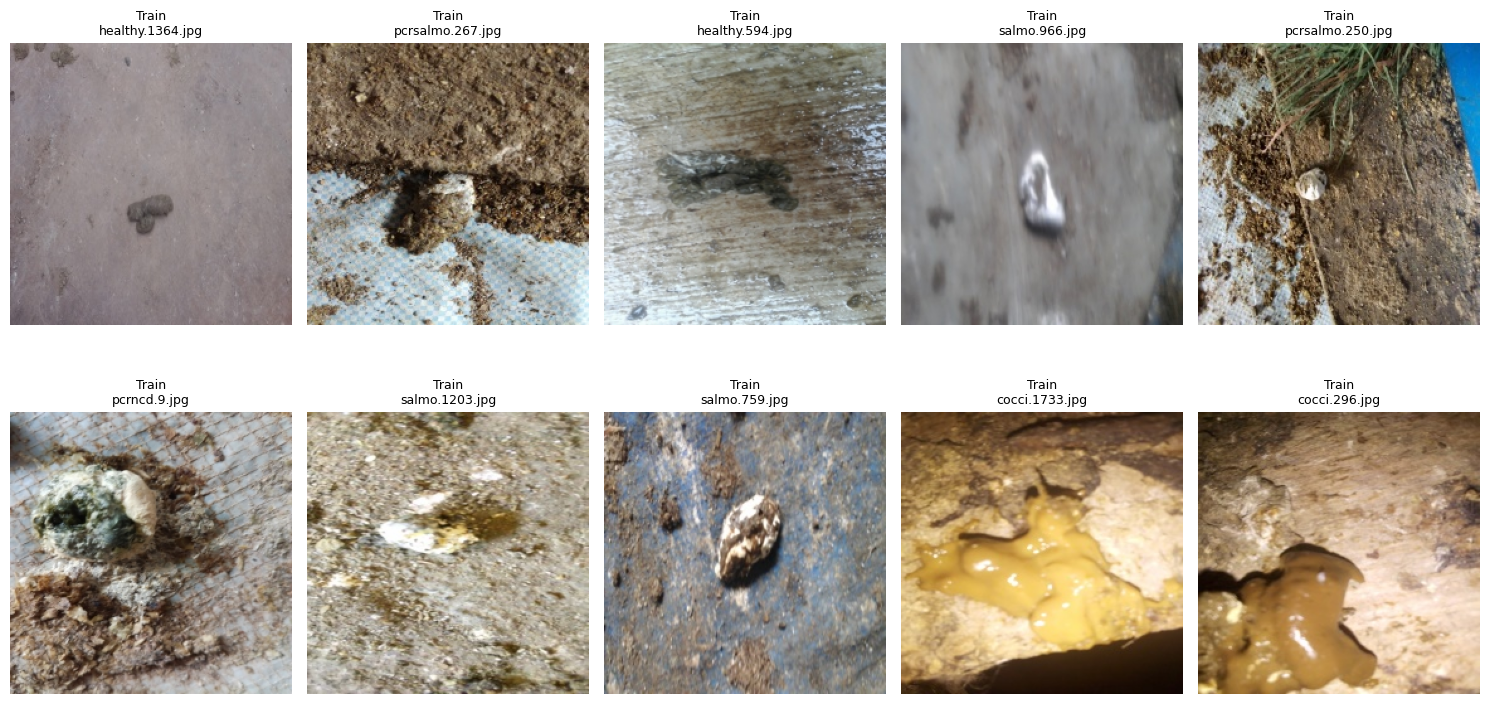

In [ ]:
FOLDER = Path("/kaggle/input/chicken-disease-1/Train")

# ambil semua file JPG, lalu acak
all_images = list(FOLDER.rglob("*.jpg"))      # rglob agar menangkap subfolder per-label
random.shuffle(all_images)
selected = all_images[:10]

plt.figure(figsize=(15,8))
for i, img_path in enumerate(selected, 1):
    img = mpimg.imread(img_path)
    plt.subplot(2,5,i)
    plt.imshow(img); plt.axis("off")
    plt.title(f"{img_path.parent.name}\n{img_path.name}", fontsize=9)  # tampilkan label & nama file
plt.tight_layout(); plt.show()

## Data Splitting

split ratio

train:val:test = 80:15:15

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

print(f"Train {train_df['label'].value_counts()} \n")
print(f"Val {val_df['label'].value_counts()} \n")
print(f"Test {test_df['label'].value_counts()} \n")

Train label
Salmonella            1896
Coccidiosis           1788
Healthy               1737
New Castle Disease     406
Name: count, dtype: int64 

Val label
Salmonella            335
Coccidiosis           316
Healthy               306
New Castle Disease     72
Name: count, dtype: int64 

Test label
Salmonella            394
Coccidiosis           372
Healthy               361
New Castle Disease     84
Name: count, dtype: int64 



## Data Augmentation

In [ ]:
df = pd.read_csv('/kaggle/input/chicken-disease-1/train_data.csv')
print(df.columns)

Index(['images', 'label'], dtype='object')


In [ ]:
train_datagen = ImageDataGenerator(
    rescale        = 1./255,
    rotation_range = 20,
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    shear_range    = 0.1,
    zoom_range     = 0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory='/kaggle/input/chicken-disease-1/Train',
    x_col='images',
    y_col='label',
    target_size=(244,244),
    class_mode='categorical',
    batch_size=32
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, directory='/kaggle/input/chicken-disease-1/Train',
    x_col='images',
    y_col='label',
    target_size=(244,244),
    class_mode='categorical',
    batch_size=32, shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, directory='/kaggle/input/chicken-disease-1/Train',
    x_col='images',
    y_col='label',
    target_size=(244,244),
    class_mode='categorical',
    batch_size=32, shuffle=False
)


Found 5827 validated image filenames belonging to 4 classes.
Found 1029 validated image filenames belonging to 4 classes.
Found 1211 validated image filenames belonging to 4 classes.


## Modelling

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(244,244,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 98s 491ms/step - accuracy: 0.5959 - loss: 1.0563 - val_accuracy: 0.7891 - val_loss: 0.6960
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 98s 537ms/step - accuracy: 0.7610 - loss: 0.6730 - val_accuracy: 0.7891 - val_loss: 0.5978
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 100s 547ms/step - accuracy: 0.7757 - loss: 0.6242 - val_accuracy: 0.8299 - val_loss: 0.5496
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 86s 471ms/step - accuracy: 0.8151 - loss: 0.5442 - val_accuracy: 0.8591 - val_loss: 0.4569
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 87s 474ms/step - accuracy: 0.8230 - loss: 0.5038 - val_accuracy: 0.7804 - val_loss: 0.6255
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 141s 469ms/step - accuracy: 0.8122 - loss: 0.5405 - val_accuracy: 0.8494 - val_loss: 0.4636
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 88s 479ms/step - accuracy: 0.8393 - loss: 0.4598 - val_accuracy: 0.8591 - val_loss: 0.4266
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 87s 472ms/step - accuracy: 0.8344 - loss:

## Evaluation

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9059 - loss: 0.2670
Test Loss: 0.2713 | Test Accuracy: 0.8984


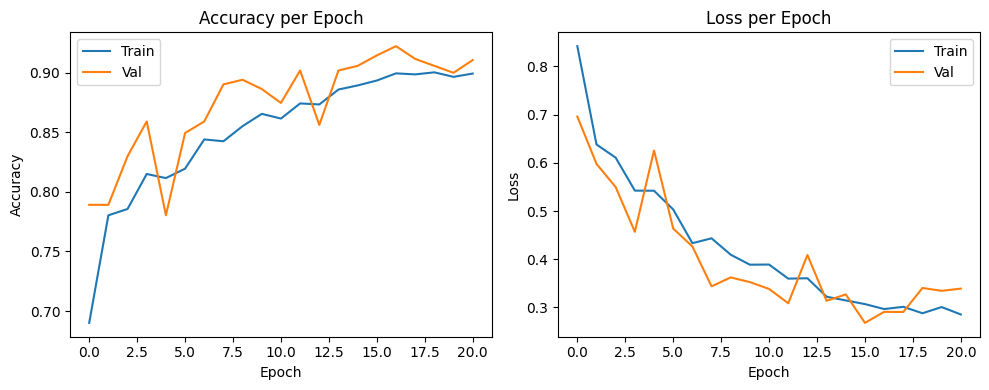

In [ ]:
# 1. Evaluasi test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# 2. Plot kurva akurasi & loss
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train')
plt.plot(epochs_range, history.history['val_loss'], label='Val')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


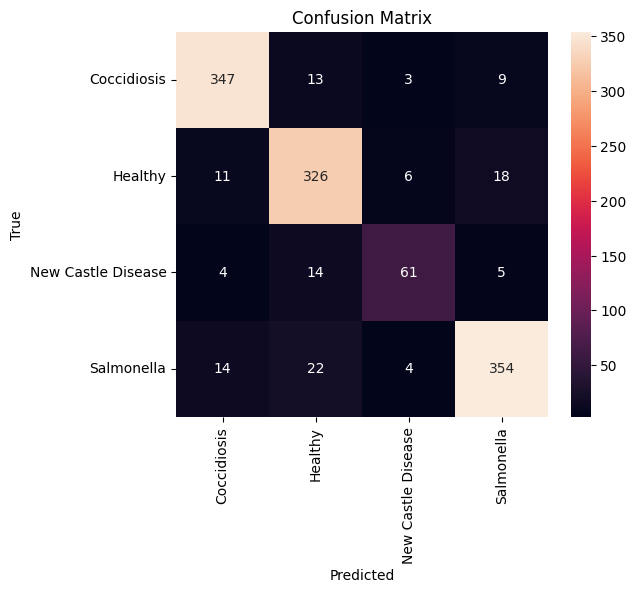

In [ ]:
# Prediksi seluruh test set
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes            # label integer ground-truth

cm = confusion_matrix(y_true, y_pred)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

predictions = model.predict(test_gen)

# The predictions will be in a one-hot encoded format, so convert them to labels
predicted_classes = np.argmax(predictions, axis=1)

# Getting the true labels from the generator
true_classes = test_gen.labels

# Getting the class labels from the generator for later use in the classification report
class_labels = list(test_gen.class_indices.keys())

# Calculate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
accuracy = accuracy_score(true_classes, predicted_classes)

print(report)
print('Accuracy:', accuracy)
# Calculate Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
                    precision    recall  f1-score   support

       Coccidiosis       0.92      0.93      0.93       372
           Healthy       0.87      0.90      0.89       361
New Castle Disease       0.82      0.73      0.77        84
        Salmonella       0.92      0.90      0.91       394

          accuracy                           0.90      1211
         macro avg       0.88      0.87      0.87      1211
      weighted avg       0.90      0.90      0.90      1211

Accuracy: 0.8984310487200661
Precision: 0.8834071109197611
Recall: 0.865127605972089
F1-Score: 0.8733803145687231


## Save Model

In [ ]:
model.save("cnn_model.h5")

In [ ]:
from google.colab import files
files.download("cnn_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
labels_ordered = list(train_gen.class_indices.keys())
print(labels_ordered)

['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']


In [ ]:
labels_by_index = sorted(train_gen.class_indices.items(), key=lambda x: x[1])
labels_by_index = [label for label, idx in labels_by_index]
print("Urutan label output:", labels_by_index)

Urutan label output: ['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']
